## 1. Load Required Libraries

In [3]:
import src.util as util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import hashlib
import json

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

## 2. Load configuration file

In [4]:
config_data = util.load_config()

## Load Train and Valid set

In [5]:
## Load function to call dataset
def load_train_clean(params: dict) -> pd.DataFrame:
    x_train = util.pickle_load(params["train_set_clean"][0])
    y_train = util.pickle_load(params["train_set_clean"][1])

    return x_train, y_train

def load_valid_clean(params:dict) -> pd.DataFrame:
    x_valid = util.pickle_load(params["valid_set_clean"][0])
    y_valid = util.pickle_load(params["valid_set_clean"][1])

    return x_valid, y_valid

def load_test_clean(params: dict) -> pd.DataFrame:
    x_test = util.pickle_load(params["test_set_clean"][0])
    y_test = util.pickle_load(params["test_set_clean"][1])

    return x_test, y_test

In [6]:
x_train, y_train = load_train_clean(config_data)
x_valid, y_valid = load_valid_clean(config_data)
x_test, y_test = load_test_clean(config_data)

# 3. Fitting Model

## 3.1 Baseline Model

In [5]:
def Baseline_model():
    dummy_clf = DummyClassifier(strategy='stratified')

    dummy_clf.fit(x_train["nonbalance"], y_train["nonbalance"])

    y_pred = dummy_clf.predict(x_train["nonbalance"])

    report = classification_report(y_true = y_train["nonbalance"],
                                    y_pred = y_pred,
                                    output_dict = True)
    report = pd.DataFrame(report)
    return report

In [6]:
## Show the baseline model of raw dataset
report = Baseline_model()

report["macro avg"]["f1-score"]

0.5134477632112447

## 3.2 Weight Model

In [7]:
def add_weight():
    sklearn_weight = compute_class_weight(class_weight = 'balanced', 
                                            classes = np.unique(y_train["nonbalance"]), 
                                            y = y_train["nonbalance"])
    sklearn_weight = dict(zip(np.unique(y_train["nonbalance"]), sklearn_weight))

    util.pickle_dump(sklearn_weight, config_data['model_params_path'][0])

    return sklearn_weight

In [8]:
sklearn_weight = add_weight()
sklearn_weight

{0: 0.6644518272425249, 1: 2.0202020202020203}

## 3.3 Baseline Model for ML model

### 3.3.1 Create Training Log

In [9]:
## Create Training log function
def training_log_template() -> dict:
    # Debug message
    util.print_debug("creating training log template.")

    # Template of training log
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
         "data_configurations" : [],
    }

    # Debug message
    util.print_debug("Training log template created.")

    # Return training log template
    return logger

In [10]:
## Create training log updater
def training_log_updater(current_log: dict, params: dict) -> list:
    # Create copy of current log
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found, create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    # Return log
    return last_log


### 3.3.2 Create Model Object of Multiple ML Model

In [11]:
## Create model object of machine learning model
def create_model_object(params: dict) -> list:
    # Debug message
    util.print_debug("Creating model objects.")

    # Create model objects
    baseline_knn = KNeighborsClassifier()
    baseline_dt = DecisionTreeClassifier()
    baseline_logreg = LogisticRegression()
    baseline_svm = SVC()
    baseline_rforest = RandomForestClassifier()
    baseline_ada = AdaBoostClassifier()
    baseline_grad = GradientBoostingClassifier()
    baseline_xgb = XGBClassifier()
    baseline_qda = QuadraticDiscriminantAnalysis()
    baseline_gnb = GaussianNB()

    # Create list of model
    list_of_model = [
        { "model_name": baseline_knn.__class__.__name__, "model_object": baseline_knn, "model_uid": ""},
        { "model_name": baseline_dt.__class__.__name__, "model_object": baseline_dt, "model_uid": ""},
        { "model_name": baseline_logreg.__class__.__name__, "model_object": baseline_logreg, "model_uid": ""},
        { "model_name": baseline_svm.__class__.__name__, "model_object": baseline_svm, "model_uid": ""},
        { "model_name": baseline_rforest.__class__.__name__, "model_object": baseline_rforest, "model_uid": ""},
        { "model_name": baseline_ada.__class__.__name__, "model_object": baseline_ada, "model_uid": ""},
        { "model_name": baseline_grad.__class__.__name__, "model_object": baseline_grad, "model_uid": ""},
        { "model_name": baseline_xgb.__class__.__name__, "model_object": baseline_xgb, "model_uid": ""},
        { "model_name": baseline_qda.__class__.__name__, "model_object": baseline_qda, "model_uid": ""},
        { "model_name": baseline_gnb.__class__.__name__, "model_object": baseline_gnb, "model_uid": ""},
    ]

    # Debug message
    util.print_debug("Model objects created.")

    # Return the list of model
    return list_of_model

### 3.3.3 Create Fitting Function

In [12]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_valid)
            performance = classification_report(y_valid, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["f1-score"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

### 3.3.4 Training Model

In [13]:
list_of_trained_model, training_log = train_eval("", config_data)

2023-01-07 22:00:17.281942 creating training log template.
2023-01-07 22:00:17.281942 Training log template created.
2023-01-07 22:00:17.282941 Training model based on configuration data: nonbalance
2023-01-07 22:00:17.282941 Creating model objects.
2023-01-07 22:00:17.282941 Model objects created.
2023-01-07 22:00:17.283941 Training model: KNeighborsClassifier
2023-01-07 22:00:17.294944 Evalutaing model: KNeighborsClassifier
2023-01-07 22:00:17.361942 Logging: KNeighborsClassifier
2023-01-07 22:00:17.364946 Model KNeighborsClassifier has been trained for configuration data nonbalance.
2023-01-07 22:00:17.364946 Training model: DecisionTreeClassifier
2023-01-07 22:00:17.416940 Evalutaing model: DecisionTreeClassifier
2023-01-07 22:00:17.440940 Logging: DecisionTreeClassifier
2023-01-07 22:00:17.442941 Model DecisionTreeClassifier has been trained for configuration data nonbalance.
2023-01-07 22:00:17.443940 Training model: LogisticRegression
2023-01-07 22:00:17.538941 Evalutaing model:

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


2023-01-07 22:00:21.825663 Training model based on configuration data: smote
2023-01-07 22:00:21.825663 Creating model objects.
2023-01-07 22:00:21.827663 Model objects created.
2023-01-07 22:00:21.834664 Training model: KNeighborsClassifier
2023-01-07 22:00:21.863666 Evalutaing model: KNeighborsClassifier
2023-01-07 22:00:21.904182 Logging: KNeighborsClassifier
2023-01-07 22:00:21.906182 Model KNeighborsClassifier has been trained for configuration data smote.
2023-01-07 22:00:21.906182 Training model: DecisionTreeClassifier
2023-01-07 22:00:22.000530 Evalutaing model: DecisionTreeClassifier
2023-01-07 22:00:22.021800 Logging: DecisionTreeClassifier
2023-01-07 22:00:22.023799 Model DecisionTreeClassifier has been trained for configuration data smote.
2023-01-07 22:00:22.023799 Training model: LogisticRegression
2023-01-07 22:00:22.094664 Evalutaing model: LogisticRegression
2023-01-07 22:00:22.115754 Logging: LogisticRegression
2023-01-07 22:00:22.116754 Model LogisticRegression has b

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


2023-01-07 22:00:31.109055 Logging: GaussianNB
2023-01-07 22:00:31.110054 Model GaussianNB has been trained for configuration data smote.
2023-01-07 22:00:31.383053 Training model based on configuration data: oversampling
2023-01-07 22:00:31.383053 Creating model objects.
2023-01-07 22:00:31.383053 Model objects created.
2023-01-07 22:00:31.393051 Training model: KNeighborsClassifier
2023-01-07 22:00:31.422052 Evalutaing model: KNeighborsClassifier
2023-01-07 22:00:31.463054 Logging: KNeighborsClassifier
2023-01-07 22:00:31.466053 Model KNeighborsClassifier has been trained for configuration data oversampling.
2023-01-07 22:00:31.466053 Training model: DecisionTreeClassifier
2023-01-07 22:00:31.540769 Evalutaing model: DecisionTreeClassifier
2023-01-07 22:00:31.561648 Logging: DecisionTreeClassifier
2023-01-07 22:00:31.563646 Model DecisionTreeClassifier has been trained for configuration data oversampling.
2023-01-07 22:00:31.563646 Training model: LogisticRegression
2023-01-07 22:00:

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


2023-01-07 22:00:42.886695 All combination models and configuration data has been trained.


### 3.3.5 Create function to save production model

In [14]:
def get_production_model(list_of_model, training_log, params):
    # Create copy list of model
    list_of_model = copy.deepcopy(list_of_model)
    
    # Debug message
    util.print_debug("Choosing model by metrics score.")

    # Create required predefined variabel
    curr_production_model = None
    prev_production_model = None
    production_model_log = None

    # Debug message
    util.print_debug("Converting training log type of data from dict to dataframe.")

    # Convert dictionary to pandas for easy operation
    training_log = pd.DataFrame(copy.deepcopy(training_log))

    # Debug message
    util.print_debug("Trying to load previous production model.")

    # Check if there is a previous production model
    try:
        prev_production_model = util.pickle_load(params["production_model_path"])
        util.print_debug("Previous production model loaded.")

    except FileNotFoundError as fe:
        util.print_debug("No previous production model detected, choosing best model only from current trained model.")

    # If previous production model detected:
    if prev_production_model != None:
        # Debug message
        util.print_debug("Loading validation data.")
        x_valid, y_valid
        
        # Debug message
        util.print_debug("Checking compatibilty previous production model's input with current train data's features.")

        # Check list features of previous production model and current dataset
        production_model_features = set(prev_production_model["model_data"]["model_object"].feature_names_in_)
        current_dataset_features = set(x_valid.columns)
        number_of_different_features = len((production_model_features - current_dataset_features) | (current_dataset_features - production_model_features))

        # If feature matched:
        if number_of_different_features == 0:
            # Debug message
            util.print_debug("Features compatible.")

            # Debug message
            util.print_debug("Reassesing previous model performance using current validation data.")

            # Re-predict previous production model to provide valid metrics compared to other current models
            y_pred = prev_production_model["model_data"]["model_object"].predict(x_valid)

            # Re-asses prediction result
            eval_res = classification_report(y_valid, y_pred, output_dict = True)

            # Debug message
            util.print_debug("Assessing complete.")

            # Debug message
            util.print_debug("Storing new metrics data to previous model structure.")

            # Update their performance log
            prev_production_model["model_log"]["performance"] = eval_res
            prev_production_model["model_log"]["f1_score_avg"] = eval_res["weighted avg"]["recall"]

            # Debug message
            util.print_debug("Adding previous model data to current training log and list of model")

            # Added previous production model log to current logs to compere who has the greatest f1 score
            training_log = pd.concat([training_log, pd.DataFrame([prev_production_model["model_log"]])])

            # Added previous production model to current list of models to choose from if it has the greatest f1 score
            list_of_model["prev_production_model"] = [copy.deepcopy(prev_production_model["model_data"])]
        else:
            # To indicate that we are not using previous production model
            prev_production_model = None

            # Debug message
            util.print_debug("Different features between production model with current dataset is detected, ignoring production dataset.")

    # Debug message
    util.print_debug("Sorting training log by f1 macro avg and training time.")

    # Sort training log by f1 score macro avg and trining time
    best_model_log = training_log.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    # Debug message
    util.print_debug("Searching model data based on sorted training log.")

    # Get model object with greatest f1 score macro avg by using UID
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_log["model_uid"]:
                curr_production_model = dict()
                curr_production_model["model_data"] = copy.deepcopy(model_data)
                curr_production_model["model_log"] = copy.deepcopy(best_model_log.to_dict())
                curr_production_model["model_log"]["model_name"] = "Production-{}".format(curr_production_model["model_data"]["model_name"])
                curr_production_model["model_log"]["training_date"] = str(curr_production_model["model_log"]["training_date"])
                production_model_log = training_log_updater(curr_production_model["model_log"], params)
                break
    
    # In case UID not found
    if curr_production_model == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    # Debug message
    util.print_debug("Model chosen.")

    # Dump chosen production model
    util.pickle_dump(curr_production_model, params["production_model_path"])
    
    # Return current chosen production model, log of production models and current training log
    return curr_production_model, production_model_log, training_log

### 3.3.6 Save Best model and Update Training Logs

In [15]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, config_data)

2023-01-07 22:00:43.383530 Choosing model by metrics score.
2023-01-07 22:00:43.383530 Converting training log type of data from dict to dataframe.
2023-01-07 22:00:43.391982 Trying to load previous production model.
2023-01-07 22:00:43.421635 Previous production model loaded.
2023-01-07 22:00:43.422635 Loading validation data.
2023-01-07 22:00:43.422635 Checking compatibilty previous production model's input with current train data's features.
2023-01-07 22:00:43.422635 Features compatible.
2023-01-07 22:00:43.422635 Reassesing previous model performance using current validation data.
2023-01-07 22:00:43.448835 Assessing complete.
2023-01-07 22:00:43.449838 Storing new metrics data to previous model structure.
2023-01-07 22:00:43.449838 Adding previous model data to current training log and list of model
2023-01-07 22:00:43.464590 Sorting training log by f1 macro avg and training time.
2023-01-07 22:00:43.472909 Searching model data based on sorted training log.
2023-01-07 22:00:43.50

## 3.3.7 BASELINE MODEL

In [16]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
training_logs[["model_name", "performance", "f1_score_avg"]].sort_values(["f1_score_avg"], ascending=False)

,model_name,performance,f1_score_avg
0,Production-GradientBoostingClassifier,"{'0': {'precision': 0.9672131147540983, 'recall': 0.7866666666666666, 'f1-score': 0.8676470588235293, 'support': 75}, '1': {'precision': 0.5897435897435898, 'recall': 0.92, 'f1-score': 0.71875, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7784783522488441, 'recall': 0.8533333333333333, 'f1-score': 0.7931985294117647, 'support': 100}, 'weighted avg': {'precision': 0.8728457335014713, 'recall': 0.82, 'f1-score': 0.830422794117647, 'support': 100}}",0.820000
26,-oversampling-GradientBoostingClassifier,"{'0': {'precision': 0.9230769230769231, 'recall': 0.8, 'f1-score': 0.8571428571428571, 'support': 75}, '1': {'precision': 0.5714285714285714, 'recall': 0.8, 'f1-score': 0.6666666666666666, 'support': 25}, 'accuracy': 0.8, 'macro avg': {'precision': 0.7472527472527473, 'recall': 0.8, 'f1-score': 0.7619047619047619, 'support': 100}, 'weighted avg': {'precision': 0.8351648351648353, 'recall': 0.8, 'f1-score': 0.8095238095238093, 'support': 100}}",0.809524
6,-nonbalance-GradientBoostingClassifier,"{'0': {'precision': 0.8767123287671232, 'recall': 0.8533333333333334, 'f1-score': 0.8648648648648648, 'support': 75}, '1': {'precision': 0.5925925925925926, 'recall': 0.64, 'f1-score': 0.6153846153846153, 'support': 25}, 'accuracy': 0.8, 'macro avg': {'precision': 0.7346524606798579, 'recall': 0.7466666666666667, 'f1-score': 0.74012474012474, 'support': 100}, 'weighted avg': {'precision': 0.8056823947234905, 'recall': 0.8, 'f1-score': 0.8024948024948024, 'support': 100}}",0.802495
17,-smote-XGBClassifier,"{'0': {'precision': 0.8857142857142857, 'recall': 0.8266666666666667, 'f1-score': 0.8551724137931035, 'support': 75}, '1': {'precision': 0.5666666666666667, 'recall': 0.68, 'f1-score': 0.6181818181818183, 'support': 25}, 'accuracy': 0.79, 'macro avg': {'precision': 0.7261904761904762, 'recall': 0.7533333333333334, 'f1-score': 0.7366771159874609, 'support': 100}, 'weighted avg': {'precision': 0.805952380952381, 'recall': 0.79, 'f1-score': 0.7959247648902822, 'support': 100}}",0.795925
11,-smote-DecisionTreeClassifier,"{'0': {'precision': 0.8840579710144928, 'recall': 0.8133333333333334, 'f1-score': 0.8472222222222223, 'support': 75}, '1': {'precision': 0.5483870967741935, 'recall': 0.68, 'f1-score': 0.6071428571428571, 'support': 25}, 'accuracy': 0.78, 'macro avg': {'precision': 0.7162225338943431, 'recall': 0.7466666666666667, 'f1-score': 0.7271825396825398, 'support': 100}, 'weighted avg': {'precision': 0.8001402524544179, 'recall': 0.78, 'f1-score': 0.787202380952381, 'support': 100}}",0.787202
16,-smote-GradientBoostingClassifier,"{'0': {'precision': 0.8840579710144928, 'recall': 0.8133333333333334, 'f1-score': 0.8472222222222223, 'support': 75}, '1': {'precision': 0.5483870967741935, 'recall': 0.68, 'f1-score': 0.6071428571428571, 'support': 25}, 'accuracy': 0.78, 'macro avg': {'precision': 0.7162225338943431, 'recall': 0.7466666666666667, 'f1-score': 0.7271825396825398, 'support': 100}, 'weighted avg': {'precision': 0.8001402524544179, 'recall': 0.78, 'f1-score': 0.787202380952381, 'support': 100}}",0.787202
27,-oversampling-XGBClassifier,"{'0': {'precision': 0.8714285714285714, 'recall': 0.8133333333333334, 'f1-score': 0.8413793103448276, 'support': 75}, '1': {'precision': 0.5333333333333333, 'recall': 0.64, 'f1-score': 0.5818181818181818, 'support': 25}, 'accuracy': 0.77, 'macro avg': {'precision': 0.7023809523809523, 'recall': 0.7266666666666667, 'f1-score': 0.7115987460815048, 'support': 100}, 'weighted avg': {'precision': 0.7869047619047619, 'recall': 0.77, 'f1-score': 0.7764890282131661, 'support': 100}}",0.776489
1,-nonbalance-DecisionTreeClassifier,"{'0': {'precision': 0.8513513513513513, 'recall': 0.84, 'f1-score': 0.8456375838926175, 'support': 75}, '1': {'precision': 0.5384615384615384, 'recall': 0.56, 'f1-score': 0.5490196078431373, 'support': 25}, 'accuracy': 0.77, 'macro avg': {'precision': 0.6949064449064448, 'recall': 0.7, 'f1

### Top 6 Baseline Model

In [17]:
print(training_logs[["model_name","f1_score_avg"]].sort_values(["f1_score_avg"], ascending=False).model_name.iloc[0:7])

util.print_debug(message="Based on training logs we can choose 6 top models.")

0        Production-GradientBoostingClassifier
26    -oversampling-GradientBoostingClassifier
6       -nonbalance-GradientBoostingClassifier
17                        -smote-XGBClassifier
11               -smote-DecisionTreeClassifier
16           -smote-GradientBoostingClassifier
27                 -oversampling-XGBClassifier
Name: model_name, dtype: object
2023-01-07 22:01:08.583887 Based on training logs we can choose 6 top models.


# 4. SEARCHING BEST PARAMS FOR ML MODEL

## 4.1. Gradient Boosting Oversampling

In [ ]:
# d_tree = DecisionTreeClassifier(max_depth=2)
n_estimators = [1,5,10,30,50,70,100,150,200,250]
max_depth = np.arange(2,11,1)
learning_rate = np.arange(0.1,1,0.1)

param_grid = {
        "n_estimators": n_estimators,
        "learning_rate" : learning_rate,
        "max_depth" : max_depth,
        }

# Buat gridsearch
grad_tree = GradientBoostingClassifier()

grad_tree_cv = RandomizedSearchCV(
                        estimator = grad_tree,
                        param_distributions = param_grid,
                        cv = 5,
                        scoring = "precision",
                        n_jobs = -1)

In [ ]:
grad_tree_cv.fit(x_train["oversampling"],y_train["oversampling"])

grad_tree_cv.best_params_

In [18]:
grad_tree = GradientBoostingClassifier(
                                    max_depth = 7,
                                    n_estimators = 70,
                                    learning_rate = 0.1,
                                    random_state=123)


grad_tree.fit(x_train["oversampling"], y_train["oversampling"])

GradientBoostingClassifier(max_depth=7, n_estimators=70, random_state=123)

In [101]:
y_valid_gb_pred_over = grad_tree.predict(x_valid)

print(classification_report(y_true = y_valid,
                            y_pred = y_valid_gb_pred_over))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89        75
           1       0.65      0.80      0.71        25

    accuracy                           0.84       100
   macro avg       0.79      0.83      0.80       100
weighted avg       0.86      0.84      0.85       100



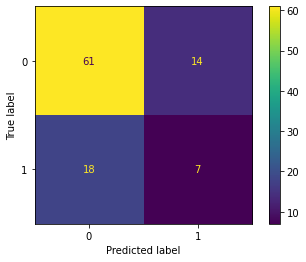

In [100]:
# Create confusion matrix list
disp_cm = list()

cm_gb_over = confusion_matrix(y_true = y_valid,
                            y_pred = y_valid_gb_pred_over)

disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_gb_over,
                               display_labels=grad_tree.classes_)
disp_cm.append(disp_1)

disp_1.plot()
plt.show()

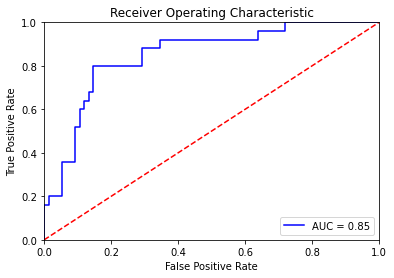

In [23]:
y_valid_gb_pred_over_proba = grad_tree.predict_proba(x_valid)

fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_valid,
                                         y_valid_gb_pred_over_proba[:, 1])
roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC = %0.2f' % roc_auc_gb_over)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4.2. Gradient Boosting Smote

In [ ]:
n_estimators = [1,5,10,30,50,70,100,150,200,250]
max_depth = np.arange(2,11,1)
learning_rate = np.arange(0.1,1,0.1)

param_grid = {
        "n_estimators": n_estimators,
        "learning_rate" : learning_rate,
        "max_depth" : max_depth
        }


grad_tree_cv = RandomizedSearchC(
                        estimator = grad_tree,
                        param_grid = param_grid,
                        cv = 5,
                        scoring = "f1_macro",
                        n_jobs = -1)

grid_result = grad_tree_cv.fit(x_train["smote"], y_train["smote"])

In [ ]:
grid_result.best_params_

In [24]:
# Manual Hyperparameter Tuning
grad_tree_smote = GradientBoostingClassifier(
                                    max_depth = 2,
                                    n_estimators = 5,
                                    learning_rate = 0.5,
                                    random_state=123)

grad_tree_smote.fit(x_train["smote"], y_train["smote"])

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=5,
                           random_state=123)

In [104]:
## Classification Report
y_valid_gb_pred_smote = grad_tree_smote.predict(x_valid)

print(classification_report(y_true = y_valid,
                            y_pred = y_valid_gb_pred_smote))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86        75
           1       0.58      0.84      0.69        25

    accuracy                           0.81       100
   macro avg       0.76      0.82      0.78       100
weighted avg       0.85      0.81      0.82       100



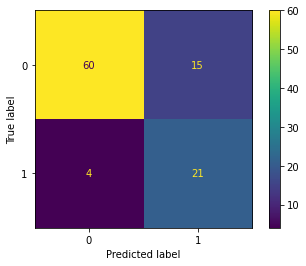

In [105]:
cm_gb_smote = confusion_matrix(y_true = y_valid,
                            y_pred = y_valid_gb_pred_smote)

disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_gb_smote,
                               display_labels=grad_tree.classes_)

disp_cm.append(disp_2)

disp_2.plot()
plt.show()

In [28]:
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # plot results
# scores = numpy.array(means).reshape(2, 5)
# plt.subplots(figsize=(20,15))
# for i, value in enumerate(max_depth):
#     plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
# plt.legend()
# plt.xlabel('n_estimators')
# plt.ylabel('Log Loss')

NameError: name 'grid_result' is not defined

## 4.3 ROC Curve Gradient Boosting on SMOTE and Oversampling dataset

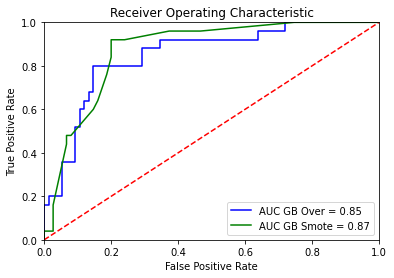

In [29]:
y_valid_gb_pred_over_proba = grad_tree.predict_proba(x_valid)
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_valid)

fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_valid,
                                         y_valid_gb_pred_over_proba[:, 1])

fpr_gb_smote, tpr_gb_smote, threshold_gb_smote = roc_curve(y_valid,
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC GB Over = %0.2f' % roc_auc_gb_over)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GB Smote = %0.2f' % roc_auc_gb_smote)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# util.pickle_dump(grad_tree, config_data['model_params_path'][4])

## 4.4. XGBOOST Smote

In [ ]:
n_estimators = [1,10,30,50,70,100,150,200,250,300]
max_depth = np.arange(2,11,1)
learning_rate = np.arange(0.1,1,0.1)
scale_pos_weight = np.arange(0.1,0.5,0.1)
gamma = np.arange(1,6,1)

xgb = XGBClassifier()

dist_params_xgb1 = {
        "n_estimators" : n_estimators,
        "learning_rate" : learning_rate,
        "max_depth" : max_depth,
        "scale_pos_weight" : scale_pos_weight,
        "gamma" : gamma,
        "random_state" : [123]
    }

xgb_cv = RandomizedSearchCV(estimator=xgb,
                      param_distributions = dist_params_xgb1,
                      cv = 5,
                      scoring = 'recall',
                      n_jobs = -1,
                      refit = True)

In [ ]:
xgb_cv.fit(x_train["smote"], y_train["smote"])

xgb_cv.best_params_

In [7]:
xgb_smote = XGBClassifier(
                    n_estimators = 7,
                    learning_rate = 0.7,
                    max_depth = 4,
                    scale_pos_weight = 0.4,
                    alpha = 5,
                    random_state=123)

xgb_smote.fit(x_train["smote"], y_train["smote"])

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.7, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=7, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [8]:
y_valid_xgb_pred_smote = xgb_smote.predict(x_valid)

print(classification_report(y_true = y_valid,
                            y_pred = y_valid_xgb_pred_smote))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        75
           1       0.68      0.60      0.64        25

    accuracy                           0.83       100
   macro avg       0.78      0.75      0.76       100
weighted avg       0.82      0.83      0.83       100



In [10]:
cm_xgb_smote = confusion_matrix(y_true = y_valid,
                            y_pred = y_valid_xgb_pred_smote)

disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_smote,
                               display_labels=grad_tree.classes_)
disp_cm.append(disp_3)

disp_3.plot()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'classes_'

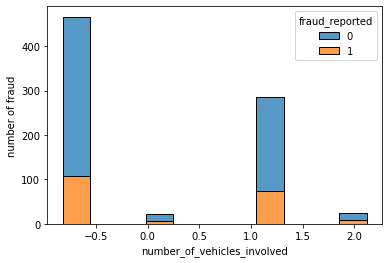

In [21]:
import seaborn as sns

train_set = pd.concat([x_train['nonbalance'], y_train['nonbalance']], axis=1)

ax = sns.histplot(data=train_set, x='number_of_vehicles_involved', multiple='stack', hue='fraud_reported')
ax.set(ylabel='number of fraud')
plt.show()

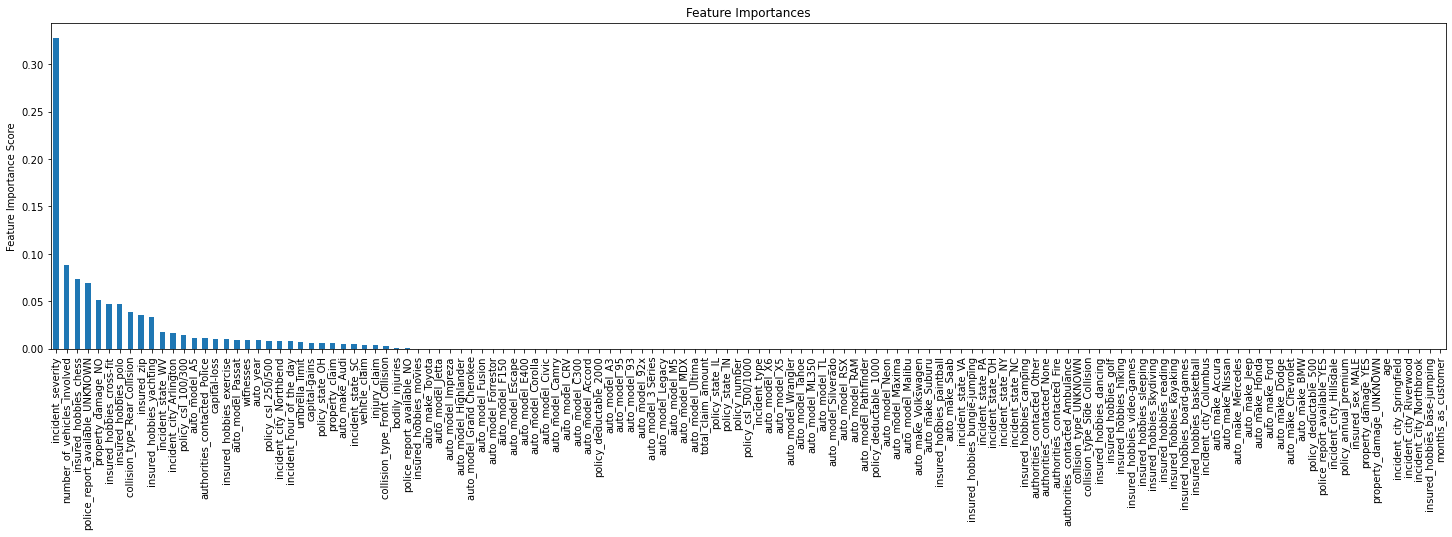

In [13]:
fig, ax = plt.subplots(figsize=(20,6))

feat_imp = pd.Series(xgb_smote.feature_importances_, x_valid.columns.to_list()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

## 4.5. XGBoosting Oversampling

In [34]:
xgb_over = XGBClassifier(
                    n_estimators = 7,
                    learning_rate = 0.7,
                    max_depth = 4,
                    scale_pos_weight = 0.4,
                    alpha = 5,
                    random_state=123)

xgb_over.fit(x_train["oversampling"], y_train["oversampling"])

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.7, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=7, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [35]:
y_valid_xgb_pred_over = xgb_over.predict(x_valid)

print(classification_report(y_true = y_valid,
                            y_pred = y_valid_xgb_pred_over))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        75
           1       0.56      0.56      0.56        25

    accuracy                           0.78       100
   macro avg       0.71      0.71      0.71       100
weighted avg       0.78      0.78      0.78       100



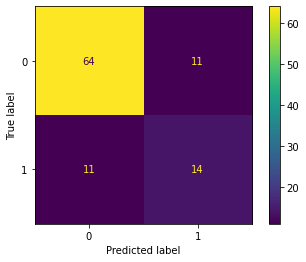

In [36]:
cm_xgb_over = confusion_matrix(y_true = y_valid,
                            y_pred = y_valid_xgb_pred_over)

disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_over,
                               display_labels=grad_tree.classes_)

disp_cm.append(disp_4)
disp_4.plot()
plt.show()

In [ ]:
# util.pickle_dump(xgb, config_data['model_params_path'][6])

## 4.6. Decision Tree

In [37]:
dt_tree = DecisionTreeClassifier(
                                max_depth = 5,
                                random_state = 123)

dt_tree.fit(x_train["smote"], y_train["smote"])

y_dt_pred = dt_tree.predict(x_train["smote"])

accuracy_score(y_true=y_train["smote"],
               y_pred=y_dt_pred)

0.9194352159468439

In [38]:
y_valid_dt_smote = dt_tree.predict(x_valid)

print(classification_report(y_true = y_valid,
                            y_pred = y_valid_dt_smote))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86        75
           1       0.58      0.88      0.70        25

    accuracy                           0.81       100
   macro avg       0.77      0.83      0.78       100
weighted avg       0.86      0.81      0.82       100



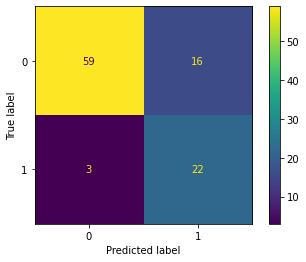

In [39]:
cm_dt = confusion_matrix(y_true = y_valid,
                            y_pred = y_valid_dt_smote)

disp_5 = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                               display_labels=grad_tree.classes_)

disp_cm.append(disp_5)
disp_5.plot()
plt.show()

## 4.7. ADABOOST

In [40]:
    dist_params_ada = {
        "base_estimator" : [DecisionTreeClassifier(max_depth = 2)],
        "n_estimators" : [3],
        "learning_rate" : [0.7],
        "random_state": [123],
    }

In [94]:
ada_over = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2),
                             n_estimators = 3,
                             learning_rate = 0.7,
                             random_state = 123)

ada_over.fit(x_train['oversampling'], y_train['oversampling'])

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.7, n_estimators=3, random_state=123)

In [95]:
y_valid_ada_over = ada_over.predict(x_valid)

print(classification_report(y_true = y_valid,
                            y_pred = y_valid_ada_over))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87        75
           1       0.59      0.92      0.72        25

    accuracy                           0.82       100
   macro avg       0.78      0.85      0.79       100
weighted avg       0.87      0.82      0.83       100



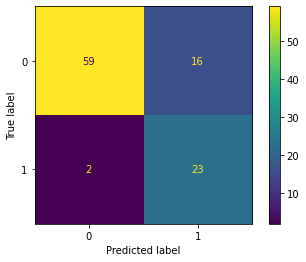

In [96]:
cm_ada = confusion_matrix(y_true = y_valid,
                      y_pred = y_valid_ada_over)

disp_6 = ConfusionMatrixDisplay(confusion_matrix=cm_ada,
                               display_labels=ada_over.classes_)

disp_cm.append(disp_6)
disp_6.plot()
plt.show()

# 5. ROC AUC PLOT

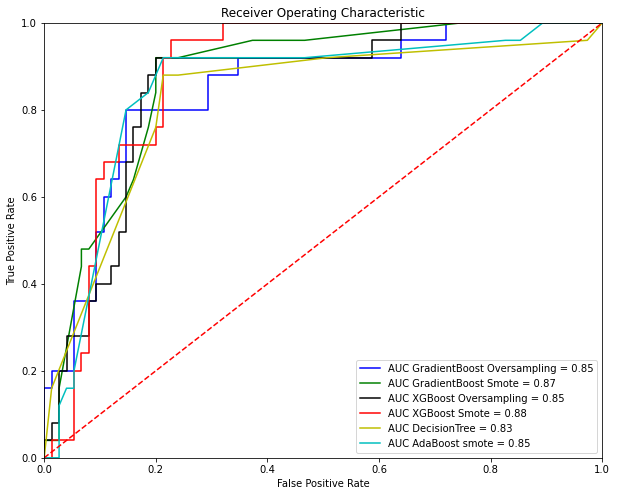

In [69]:
## Create Proba for all function
y_valid_xgb_over_proba = xgb_over.predict_proba(x_valid)
y_valid_xgb_smote_proba = xgb_smote.predict_proba(x_valid)
y_valid_dt_proba = dt_tree.predict_proba(x_valid)
y_valid_ada_over_proba = ada_over.predict_proba(x_valid)
y_valid_gb_pred_over_proba = grad_tree.predict_proba(x_valid)
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_valid)

## ROC CURVE Function for create FPR & TPR
fpr_xgb_over, tpr_xgb_over, threshold_xgb_over = roc_curve(y_valid,
                                         y_valid_xgb_over_proba[:, 1])
fpr_xgb_smote, tpr_xgb_smote, threshold_xgb_smote = roc_curve(y_valid,
                                         y_valid_xgb_smote_proba[:, 1])
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_valid,
                                        y_valid_dt_proba[:, 1])
fpr_ada_over, tpr_ada_over, threshold_ada_over = roc_curve(y_valid,
                                                           y_valid_ada_over_proba[:, 1])
fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_valid,
                                         y_valid_gb_pred_over_proba[:, 1])

fpr_gb_smote, tpr_gb_smote, threshold_gb_smote = roc_curve(y_valid,
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_xgb_over = auc(fpr_xgb_over, tpr_xgb_over)
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_ada_over = auc(fpr_ada_over, tpr_ada_over)
roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)


plt.subplots(figsize=(10,8))
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC GradientBoost Oversampling = %0.2f' % roc_auc_gb_over)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GradientBoost Smote = %0.2f' % roc_auc_gb_smote)
plt.plot(fpr_xgb_over, tpr_xgb_over, 'k', label = 'AUC XGBoost Oversampling = %0.2f' % roc_auc_xgb_over)
plt.plot(fpr_xgb_smote, tpr_xgb_smote, 'r', label = 'AUC XGBoost Smote = %0.2f' % roc_auc_xgb_smote)
plt.plot(fpr_dt, tpr_dt, 'y', label = 'AUC DecisionTree = %0.2f' % roc_auc_dt)
plt.plot(fpr_ada_over, tpr_ada_over, 'c', label = 'AUC AdaBoost smote = %0.2f' % roc_auc_ada_over)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5.1. Confusion Matrix

In [ ]:
# fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15,12), sharex=False, sharey=False)
# axes = axes.ravel()
# cols = 
labels = ['gb_over', 'gb_smote', 'xgb_smote', 'xgb_over', 'dt', 'ada']

# disp_cm_test = disp_cm.copy()

for cm, label in zip(disp_cm, labels):
    plt.title(label)
    cm.plot()

    plt.show()

# 6. Hyperparameter Tuning

## 6.1 Create Param Distribution

In [71]:
def create_dist_params(model_name: str) -> dict:
    # Define models paramteres   
    dist_params_xgb = {
        "n_estimators" : [7],
        "learning_rate" : [0.7],
        "max_depth" : [4],
        "alpha" : [5],
        "scale_pos_weight" : [0.4],
    }
    dist_params_gb = {
        "max_depth" : [2],
        "n_estimators" : [5],
        "learning_rate" : [0.5],
    }
    dist_params_ada = {
        "base_estimator" : [DecisionTreeClassifier(max_depth = 2)],
        "n_estimators" : [3],
        "learning_rate" : [0.7],
    }
    dist_params_dt = {
        "max_depth" : [5],
    }

    # Make all models parameters in to one
    dist_params = {
        "XGBClassifier": dist_params_xgb,
        "GradientBoostingClassifier": dist_params_gb,
        "AdaBoostClassifier": dist_params_ada,
        "DecisionTreeClassifier": dist_params_dt
    }

    # Return distribution of model parameters
    return dist_params[model_name]

In [72]:
def hyper_params_tuning(model: list) -> list:
    # Create copy of current best baseline model
    model_list = []
    trained_model = [XGBClassifier(),GradientBoostingClassifier(),AdaBoostClassifier(),DecisionTreeClassifier()]
    
    # Create model object
    for col, mod in list(zip(model, trained_model)):
        dist_params = create_dist_params(col)
        model_rsc = GridSearchCV(mod, dist_params, n_jobs = -1)
        model_ = {
                        "model_name": col,
                        "model_object": model_rsc,
                        "model_uid": ""
                    }
            
        model_list.append(model_.copy())
    
    # Return model object
    return model_list

### 6.2 run debugging

In [ ]:
listmodel_ = hyper_params_tuning(['XGBClassifier',
                                  'GradientBoostingClassifier', 
                                  'AdaBoostClassifier',
                                  'DecisionTreeClassifier'])

listmodel_

In [ ]:
## Sanity Check
x_test.shape == x_valid.shape

## 6.3 Create Training Function based on Validation

In [60]:
def train_eval_valid(configuration_model: str, params: dict, hyperparams_model: list = None):
    # Load dataset
    # x_train, y_train, \
    # x_valid, y_valid, \
    # x_test, y_test = load_dataset(params)

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_valid)
            performance = classification_report(y_valid, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["recall"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

## 6.4 Training model and update Training Logs

In [73]:
list_of_trained_model_valid, \
training_log_valid = train_eval_valid("Hyperparams", 
                                    config_data,
                                    hyper_params_tuning(['XGBClassifier',
                                                          'GradientBoostingClassifier', 
                                                          'AdaBoostClassifier',
                                                          'DecisionTreeClassifier']))

2023-01-07 22:15:31.071627 creating training log template.
2023-01-07 22:15:31.071627 Training log template created.
2023-01-07 22:15:31.071627 Training model based on configuration data: nonbalance
2023-01-07 22:15:31.073625 Training model: XGBClassifier
2023-01-07 22:15:31.917829 Evalutaing model: XGBClassifier
2023-01-07 22:15:31.964822 Logging: XGBClassifier
2023-01-07 22:15:31.974823 Model XGBClassifier has been trained for configuration data nonbalance.
2023-01-07 22:15:31.974823 Training model: GradientBoostingClassifier
2023-01-07 22:15:32.217328 Evalutaing model: GradientBoostingClassifier
2023-01-07 22:15:32.237357 Logging: GradientBoostingClassifier
2023-01-07 22:15:32.244982 Model GradientBoostingClassifier has been trained for configuration data nonbalance.
2023-01-07 22:15:32.244982 Training model: AdaBoostClassifier
2023-01-07 22:15:32.498412 Evalutaing model: AdaBoostClassifier
2023-01-07 22:15:32.547412 Logging: AdaBoostClassifier
2023-01-07 22:15:32.553410 Model AdaBo

### 6.4.1. Display Best Model

In [91]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
pd.DataFrame(training_log_valid)[['model_name',
                                 'training_time',
                                 'performance',
                                 'f1_score_avg']].sort_values(["f1_score_avg", "training_time"], ascending = [False, True])

,model_name,training_time,performance,f1_score_avg
4,Hyperparams-smote-XGBClassifier,0.952034,"{'0': {'precision': 0.8717948717948718, 'recall': 0.9066666666666666, 'f1-score': 0.8888888888888887, 'support': 75}, '1': {'precision': 0.6818181818181818, 'recall': 0.6, 'f1-score': 0.6382978723404256, 'support': 25}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7768065268065267, 'recall': 0.7533333333333333, 'f1-score': 0.7635933806146571, 'support': 100}, 'weighted avg': {'precision': 0.8243006993006994, 'recall': 0.83, 'f1-score': 0.826241134751773, 'support': 100}}",0.83
9,Hyperparams-oversampling-GradientBoostingClassifier,0.445997,"{'0': {'precision': 0.9672131147540983, 'recall': 0.7866666666666666, 'f1-score': 0.8676470588235293, 'support': 75}, '1': {'precision': 0.5897435897435898, 'recall': 0.92, 'f1-score': 0.71875, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7784783522488441, 'recall': 0.8533333333333333, 'f1-score': 0.7931985294117647, 'support': 100}, 'weighted avg': {'precision': 0.8728457335014713, 'recall': 0.82, 'f1-score': 0.830422794117647, 'support': 100}}",0.82
10,Hyperparams-oversampling-AdaBoostClassifier,0.507705,"{'0': {'precision': 0.9672131147540983, 'recall': 0.7866666666666666, 'f1-score': 0.8676470588235293, 'support': 75}, '1': {'precision': 0.5897435897435898, 'recall': 0.92, 'f1-score': 0.71875, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7784783522488441, 'recall': 0.8533333333333333, 'f1-score': 0.7931985294117647, 'support': 100}, 'weighted avg': {'precision': 0.8728457335014713, 'recall': 0.82, 'f1-score': 0.830422794117647, 'support': 100}}",0.82
6,Hyperparams-smote-AdaBoostClassifier,0.569004,"{'0': {'precision': 0.9384615384615385, 'recall': 0.8133333333333334, 'f1-score': 0.8714285714285714, 'support': 75}, '1': {'precision': 0.6, 'recall': 0.84, 'f1-score': 0.7000000000000001, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7692307692307692, 'recall': 0.8266666666666667, 'f1-score': 0.7857142857142858, 'support': 100}, 'weighted avg': {'precision': 0.8538461538461539, 'recall': 0.82, 'f1-score': 0.8285714285714286, 'support': 100}}",0.82
2,Hyperparams-nonbalance-AdaBoostClassifier,0.252431,"{'0': {'precision': 0.9242424242424242, 'recall': 0.8133333333333334, 'f1-score': 0.8652482269503545, 'support': 75}, '1': {'precision': 0.5882352941176471, 'recall': 0.8, 'f1-score': 0.6779661016949153, 'support': 25}, 'accuracy': 0.81, 'macro avg': {'precision': 0.7562388591800356, 'recall': 0.8066666666666666, 'f1-score': 0.771607164322635, 'support': 100}, 'weighted avg': {'precision': 0.8402406417112299, 'recall': 0.81, 'f1-score': 0.8184276956364946, 'support': 100}}",0.81
5,Hyperparams-smote-GradientBoostingClassifier,0.633001,"{'0': {'precision': 0.9375, 'recall': 0.8, 'f1-score': 0.8633093525179856, 'support': 75}, '1': {'precision': 0.5833333333333334, 'recall': 0.84, 'f1-score': 0.6885245901639344, 'support': 25}, 'accuracy': 0.81, 'macro avg': {'precision': 0.7604166666666667, 'recall': 0.8200000000000001, 'f1-score': 0.7759169713409599, 'support': 100}, 'weighted avg': {'precision': 0.8489583333333333, 'recall': 0.81, 'f1-score': 0.8196131619294728, 'support': 100}}",0.81
3,Hyperparams-nonbalance-DecisionTreeClassifier,0.170997,"{'0': {'precision': 0.8767123287671232, 'recall': 0.8533333333333334, 'f1-score': 0.8648648648648648, 'support': 75}, '1': {'precision': 0.5925925925925926, 'recall': 0.64, 'f1-score': 0.6153846153846153, 'support': 25}, 'accuracy': 0.8, 'macro avg': {'precision': 0.7346524606798579, 'recall': 0.7466666666666667, 'f1-score': 0.74012474012474, 'support': 100}, 'weighted avg': {'precision': 0.8056823947234905, 'recall': 0.8, 'f1-score': 0.8024948024948024, 'support': 100}}",0.80
11,Hyperparams-oversampling-DecisionTreeClassifier,0.446059,"{'0': {'precision': 0.9365079365079365, 'recall': 0.7866666666666666, 'f1-score': 0.8550724637681159, 'support': 75}, '1': {'precision': 0.5675675675675675, 'recall': 0.84, 'f1-

# 7. Test Data

## 7.1 Create ROC Curve based on Test Data

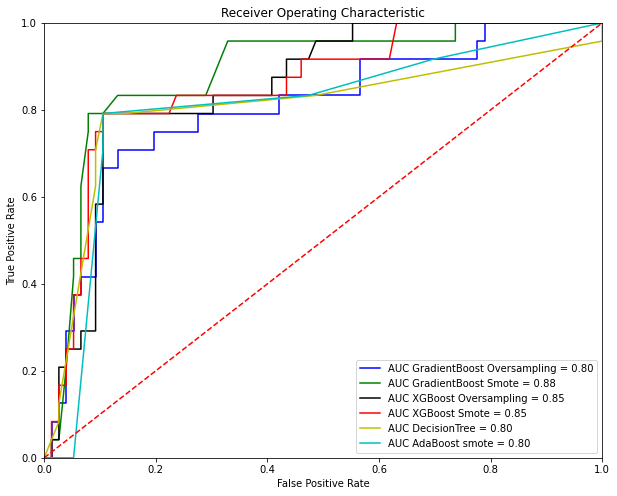

In [97]:
## Create Proba for all function
y_valid_xgb_over_proba = xgb_over.predict_proba(x_test)
y_valid_xgb_smote_proba = xgb_smote.predict_proba(x_test)
y_valid_dt_proba = dt_tree.predict_proba(x_test)
y_valid_ada_over_proba = ada_over.predict_proba(x_test)
y_valid_gb_pred_over_proba = grad_tree.predict_proba(x_test)
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_test)

## ROC CURVE Function for create FPR & TPR
fpr_xgb_over, tpr_xgb_over, threshold_xgb_over = roc_curve(y_test,
                                         y_valid_xgb_over_proba[:, 1])
fpr_xgb_smote, tpr_xgb_smote, threshold_xgb_smote = roc_curve(y_test,
                                         y_valid_xgb_smote_proba[:, 1])
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test,
                                        y_valid_dt_proba[:, 1])
fpr_ada_over, tpr_ada_over, threshold_ada_over = roc_curve(y_test,
                                                           y_valid_ada_over_proba[:, 1])
fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_test,
                                         y_valid_gb_pred_over_proba[:, 1])

fpr_gb_smote, tpr_gb_smote, threshold_gb_smote = roc_curve(y_test,
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_xgb_over = auc(fpr_xgb_over, tpr_xgb_over)
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_ada_over = auc(fpr_ada_over, tpr_ada_over)
roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)


plt.subplots(figsize=(10,8))
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC GradientBoost Oversampling = %0.2f' % roc_auc_gb_over)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GradientBoost Smote = %0.2f' % roc_auc_gb_smote)
plt.plot(fpr_xgb_over, tpr_xgb_over, 'k', label = 'AUC XGBoost Oversampling = %0.2f' % roc_auc_xgb_over)
plt.plot(fpr_xgb_smote, tpr_xgb_smote, 'r', label = 'AUC XGBoost Smote = %0.2f' % roc_auc_xgb_smote)
plt.plot(fpr_dt, tpr_dt, 'y', label = 'AUC DecisionTree = %0.2f' % roc_auc_dt)
plt.plot(fpr_ada_over, tpr_ada_over, 'c', label = 'AUC AdaBoost smote = %0.2f' % roc_auc_ada_over)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 7.2 Create Function to Eval Test Data

In [63]:
def train_eval_test(configuration_model: str, params: dict, hyperparams_model: list = None):

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_test)
            performance = classification_report(y_test, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["recall"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

## 7.3 Training Dataset and Update Training Logs

In [75]:
list_of_trained_model_test, \
training_log_test = train_eval_test("Hyperparams", 
                                    config_data,
                                    hyper_params_tuning(['XGBClassifier',
                                                          'GradientBoostingClassifier', 
                                                          'AdaBoostClassifier',
                                                          'DecisionTreeClassifier']))

2023-01-07 22:16:01.574957 creating training log template.
2023-01-07 22:16:01.575956 Training log template created.
2023-01-07 22:16:01.575956 Training model based on configuration data: nonbalance
2023-01-07 22:16:01.577959 Training model: XGBClassifier
2023-01-07 22:16:02.180261 Evalutaing model: XGBClassifier
2023-01-07 22:16:02.232262 Logging: XGBClassifier
2023-01-07 22:16:02.244276 Model XGBClassifier has been trained for configuration data nonbalance.
2023-01-07 22:16:02.244276 Training model: GradientBoostingClassifier
2023-01-07 22:16:02.539229 Evalutaing model: GradientBoostingClassifier
2023-01-07 22:16:02.562647 Logging: GradientBoostingClassifier
2023-01-07 22:16:02.569643 Model GradientBoostingClassifier has been trained for configuration data nonbalance.
2023-01-07 22:16:02.569643 Training model: AdaBoostClassifier
2023-01-07 22:16:02.815179 Evalutaing model: AdaBoostClassifier
2023-01-07 22:16:02.840880 Logging: AdaBoostClassifier
2023-01-07 22:16:02.844880 Model AdaBo

## 7.4 Check Best Model

In [93]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
pd.DataFrame(training_log_test)[['model_name',
                                 'training_time',
                                 'performance',
                                 'f1_score_avg']].sort_values(["f1_score_avg", "training_time"], ascending = [False, True])

,model_name,training_time,performance,f1_score_avg
5,Hyperparams-smote-GradientBoostingClassifier,0.509681,"{'0': {'precision': 0.9333333333333333, 'recall': 0.9210526315789473, 'f1-score': 0.9271523178807947, 'support': 76}, '1': {'precision': 0.76, 'recall': 0.7916666666666666, 'f1-score': 0.7755102040816326, 'support': 24}, 'accuracy': 0.89, 'macro avg': {'precision': 0.8466666666666667, 'recall': 0.8563596491228069, 'f1-score': 0.8513312609812136, 'support': 100}, 'weighted avg': {'precision': 0.8917333333333335, 'recall': 0.89, 'f1-score': 0.8907582105689958, 'support': 100}}",0.89
10,Hyperparams-oversampling-AdaBoostClassifier,0.439040,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
9,Hyperparams-oversampling-GradientBoostingClassifier,0.470805,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
7,Hyperparams-smote-DecisionTreeClassifier,0.333900,"{'0': {'precision': 0.918918918918919, 'recall': 0.8947368421052632, 'f1-score': 0.9066666666666667, 'support': 76}, '1': {'precision': 0.6923076923076923, 'recall': 0.75, 'f1-score': 0.7199999999999999, 'support': 24}, 'accuracy': 0.86, 'macro avg': {'precision': 0.8056133056133057, 'recall': 0.8223684210526316, 'f1-score': 0.8133333333333332, 'support': 100}, 'weighted avg': {'precision': 0.8645322245322246, 'recall': 0.86, 'f1-score': 0.8618666666666667, 'support': 100}}",0.86
6,Hyperparams-smote-AdaBoostClassifier,0.501836,"{'0': {'precision': 0.875, 'recall': 0.9210526315789473, 'f1-score': 0.8974358974358975, 'support': 76}, '1': {'precision': 0.7, 'recall': 0.5833333333333334, 'f1-score': 0.6363636363636365, 'support': 24}, 'accuracy': 0.84, 'macro avg': {'precision': 0.7875, 'recall': 0.7521929824561404, 'f1-score': 0.766899766899767, 'support': 100}, 'weighted avg': {'precision': 0.833, 'recall': 0.84, 'f1-score': 0.8347785547785549, 'support': 100}}",0.84
2,Hyperparams-nonbalance-AdaBoostClassifier,0.243534,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
4,Hyperparams-smote-XGBClassifier,0.899158,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
3,Hyperparams-nonbalance-DecisionTreeClassifier,0.180763,"{'0': {'precision': 0.8625, 'recall': 0.9078947368421053, 'f1-score': 0.8846153846153847, 'support': 76}, 

# 8. Save Production Model

In [106]:
model_test, \
production_model_log_test, \
training_logs_test = get_production_model(list_of_trained_model_test, 
                                          training_log_test, 
                                          config_data)

2023-01-07 23:21:23.121474 Choosing model by metrics score.
2023-01-07 23:21:23.121474 Converting training log type of data from dict to dataframe.
2023-01-07 23:21:23.128473 Trying to load previous production model.
2023-01-07 23:21:23.176474 Previous production model loaded.
2023-01-07 23:21:23.176474 Loading validation data.
2023-01-07 23:21:23.176474 Checking compatibilty previous production model's input with current train data's features.
2023-01-07 23:21:23.177473 Features compatible.
2023-01-07 23:21:23.177473 Reassesing previous model performance using current validation data.
2023-01-07 23:21:23.206476 Assessing complete.
2023-01-07 23:21:23.206476 Storing new metrics data to previous model structure.
2023-01-07 23:21:23.206476 Adding previous model data to current training log and list of model
2023-01-07 23:21:23.216478 Sorting training log by f1 macro avg and training time.
2023-01-07 23:21:23.221474 Searching model data based on sorted training log.
2023-01-07 23:21:23.25

## 8.1 Show Best Final Model

In [107]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')

training_logs_test[["model_name","training_time","performance","f1_score_avg"]].sort_values(["f1_score_avg"], ascending=False)

,model_name,training_time,performance,f1_score_avg
5,Hyperparams-smote-GradientBoostingClassifier,0.509681,"{'0': {'precision': 0.9333333333333333, 'recall': 0.9210526315789473, 'f1-score': 0.9271523178807947, 'support': 76}, '1': {'precision': 0.76, 'recall': 0.7916666666666666, 'f1-score': 0.7755102040816326, 'support': 24}, 'accuracy': 0.89, 'macro avg': {'precision': 0.8466666666666667, 'recall': 0.8563596491228069, 'f1-score': 0.8513312609812136, 'support': 100}, 'weighted avg': {'precision': 0.8917333333333335, 'recall': 0.89, 'f1-score': 0.8907582105689958, 'support': 100}}",0.89
9,Hyperparams-oversampling-GradientBoostingClassifier,0.470805,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
10,Hyperparams-oversampling-AdaBoostClassifier,0.439040,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
7,Hyperparams-smote-DecisionTreeClassifier,0.333900,"{'0': {'precision': 0.918918918918919, 'recall': 0.8947368421052632, 'f1-score': 0.9066666666666667, 'support': 76}, '1': {'precision': 0.6923076923076923, 'recall': 0.75, 'f1-score': 0.7199999999999999, 'support': 24}, 'accuracy': 0.86, 'macro avg': {'precision': 0.8056133056133057, 'recall': 0.8223684210526316, 'f1-score': 0.8133333333333332, 'support': 100}, 'weighted avg': {'precision': 0.8645322245322246, 'recall': 0.86, 'f1-score': 0.8618666666666667, 'support': 100}}",0.86
6,Hyperparams-smote-AdaBoostClassifier,0.501836,"{'0': {'precision': 0.875, 'recall': 0.9210526315789473, 'f1-score': 0.8974358974358975, 'support': 76}, '1': {'precision': 0.7, 'recall': 0.5833333333333334, 'f1-score': 0.6363636363636365, 'support': 24}, 'accuracy': 0.84, 'macro avg': {'precision': 0.7875, 'recall': 0.7521929824561404, 'f1-score': 0.766899766899767, 'support': 100}, 'weighted avg': {'precision': 0.833, 'recall': 0.84, 'f1-score': 0.8347785547785549, 'support': 100}}",0.84
2,Hyperparams-nonbalance-AdaBoostClassifier,0.243534,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
4,Hyperparams-smote-XGBClassifier,0.899158,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
3,Hyperparams-nonbalance-DecisionTreeClassifier,0.180763,"{'0': {'precision': 0.8625, 'recall': 0.9078947368421053, 'f1-score': 0.8846153846153847, 'support': 76}, 

In [108]:
model_test["model_data"]["model_object"]

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5], 'max_depth': [2],
                         'n_estimators': [5]})

# 9. Check Production Model

In [109]:
check_model = util.pickle_load(config_data['production_model_path'])

In [110]:
check_model

{'model_data': {'model_name': 'GradientBoostingClassifier',
  'model_object': GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
               param_grid={'learning_rate': [0.5], 'max_depth': [2],
                           'n_estimators': [5]}),
  'model_uid': 'fa0af7ba956c1b9675f7f0ffe2f7467d'},
 'model_log': {'model_name': 'Production-GradientBoostingClassifier',
  'model_uid': 'fa0af7ba956c1b9675f7f0ffe2f7467d',
  'training_time': 0.509681,
  'training_date': '2023-01-07 22:16:04.572480',
  'performance': {'0': {'precision': 0.9333333333333333,
    'recall': 0.9210526315789473,
    'f1-score': 0.9271523178807947,
    'support': 76},
   '1': {'precision': 0.76,
    'recall': 0.7916666666666666,
    'f1-score': 0.7755102040816326,
    'support': 24},
   'accuracy': 0.89,
   'macro avg': {'precision': 0.8466666666666667,
    'recall': 0.8563596491228069,
    'f1-score': 0.8513312609812136,
    'support': 100},
   'weighted avg': {'precision': 0.8917333333333335,
    'rec